## Introduction

Kaggle recently published the results of their 2017 data science survey. As someone with a budding interest in data science, I figured I'd try to find how the results could be useful to people like me, who are trying to figure out how to get started.

### Installing necessary packages

In [6]:
library(data.table)
library(dplyr, quietly = TRUE)
library(ggplot2)
library(tibble)

### Loading data

I like using tibbles for large data frames, as they make it easier to view in the R interactive prompt.

In [8]:
results <- as.tibble(suppressWarnings(fread("./data/multipleChoiceResponses.csv")))

We can easily see how many people responded to the survey...

In [3]:
nrow(results)

[1] 16716

...and how many questions were asked.

In [4]:
ncol(results)

[1] 228

With 228(!) questions and 17,000 respondents, there's clearly a lot to analyze. Let's get started!

## Programming language

From what I understand, one of the first questions many data scientists have to answer is which language they want to write their code in. In this graph, we'll see how Python and R stack up against each other as recommendations based on participants' job titles.

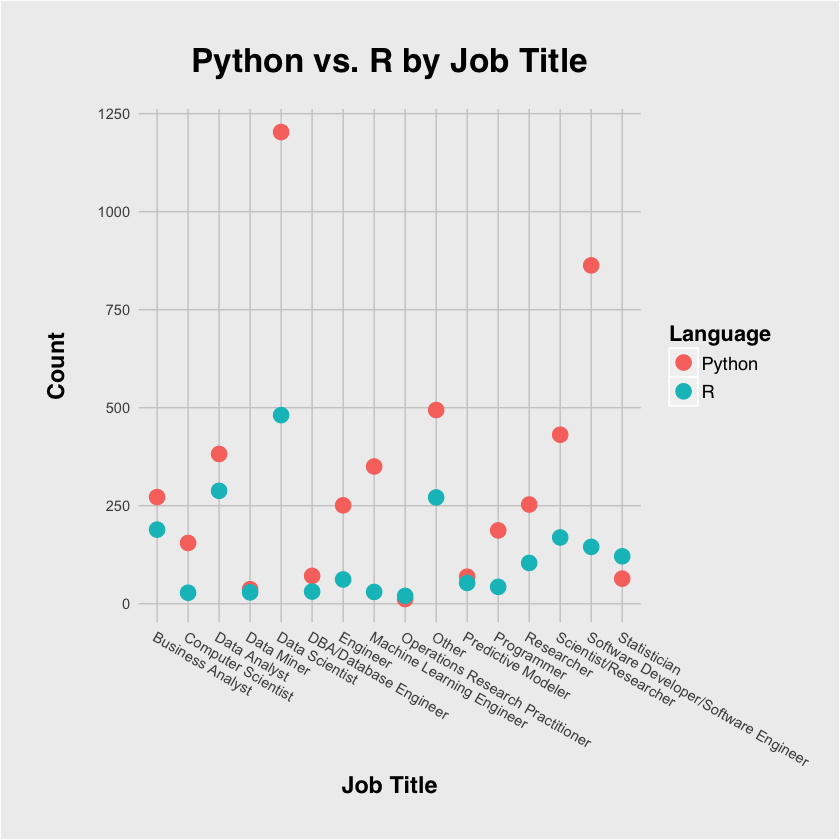

In [10]:
results %>%
    rename(Language = LanguageRecommendationSelect, title = CurrentJobTitleSelect) %>%
    filter(Language == "R" | Language == "Python") %>%
    filter(title != "") %>%
    group_by(title, Language) %>%
    count() %>%
    ggplot(aes(title, n, color = Language)) +
    ggtitle("Python vs. R by Job Title") +
    labs(x = "Job Title", y = "Count") +
    geom_point(size = 4) +
    theme(
        plot.background = element_rect(fill = "#eeeeee"),
        panel.background = element_rect(fill = "#eeeeee"),
        legend.background = element_rect(fill = "#eeeeee"),
        legend.title = element_text(size = 13, family = "Helvetica", face = "bold"),
        legend.text = element_text(size = 11, family = "Helvetica"),
        panel.grid.major = element_line(size = 0.4, linetype = "solid", color = "#cccccc"),
        panel.grid.minor = element_line(size = 0),
        plot.title = element_text(size = 20, family = "Helvetica", face = "bold", hjust = 0.5, margin = margin(b = 20)),
        axis.title = element_text(size = 14, family = "Helvetica", face = "bold"),
        axis.text.x = element_text(angle = 330, hjust = 0),
        axis.title.y = element_text(margin = margin(r = 20)),
        axis.ticks = element_blank(),
        plot.margin = unit(c(1, 1.25, 1, 1), "cm")
    )

As we can see, **Python is favored for beginners over R in almost every scenario**, and notably so for data scientists, software developers, and machine learning engineers. However, R is slightly favored by statisticians.

## Resources for learning

One of the first questions in the survey asked participants how useful certain resources are for learning data science skills. For our first graph, we'll plot each resource's usefulness against its popularity. We can see if some resources are overhyped, or if some aren't being used enough. Popularity is determined by how many people answered the question for this resource, and usefulness is computed as a weighted average, with 1 point awarded for each "very useful" answer, half a point for each "somewhat useful" answer, and 0 points for each "not useful" answer.

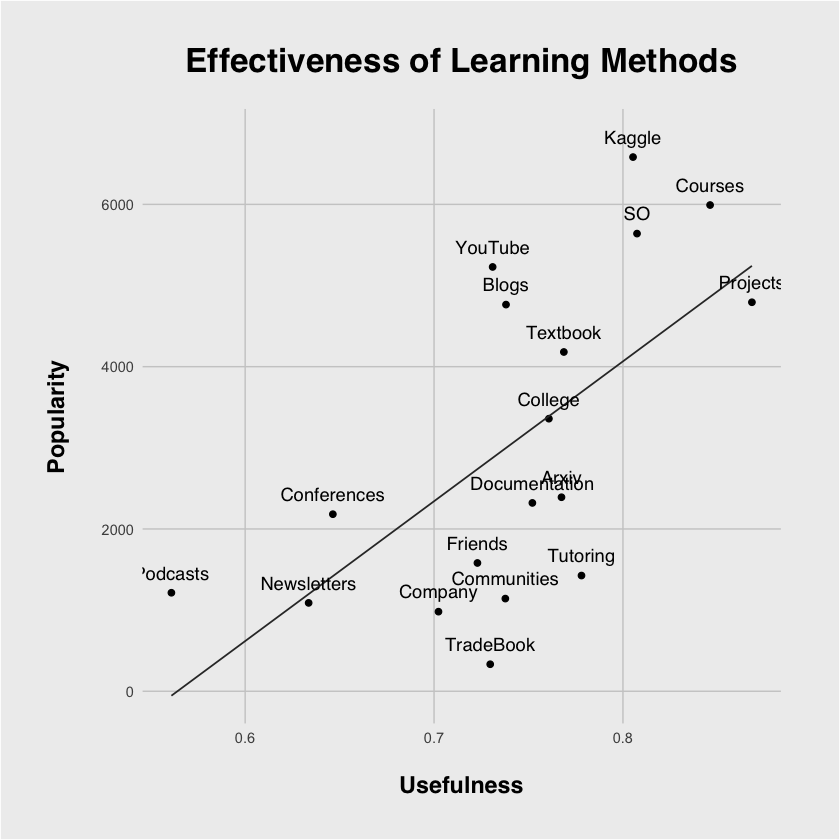

In [11]:
# Get all column names that begin with "LearningPlatformUsefulness"
platforms <- grep("^LearningPlatformUsefulness", names(results), value=T)

names <- c()
popularities <- c()
scores <- c()

for (platform in platforms) {
    usefulness <- results %>%
        group_by_(platform) %>%
        count()
    
    # Popularity = the number of people who responded to this question
    popularity <- usefulness[[2]][2] + usefulness[[2]][3] + usefulness[[2]][4]
    
    # Usefulness = a weighted average determining the usefulness of this platform
    score <- (usefulness[[2]][2] * 0 + usefulness[[2]][3] * 0.5 + usefulness[[2]][4] * 1) / popularity
    
    names <- c(names, gsub("LearningPlatformUsefulness", "", platform))
    popularities <- c(popularities, popularity)
    scores <- c(scores, score)
}

scores_df <- data.frame(
    Popularity = popularities,
    Usefulness = scores,
    Name = names
)

ggplot(scores_df, aes(x = Usefulness, y = Popularity)) +
    ggtitle("Effectiveness of Learning Methods") +
    geom_point() +
    geom_smooth(method = lm, se = FALSE, color = "#333333", size = 0.5) +
    geom_text(aes(label = Name, family = "Helvetica"), nudge_y = 250) +
    theme(
        plot.background = element_rect(fill = "#eeeeee"),
        panel.background = element_rect(fill = "#eeeeee"),
        panel.grid.major = element_line(size = 0.4, linetype = "solid", color = "#cccccc"),
        panel.grid.minor = element_line(size = 0),
        plot.title = element_text(size = 20, family = "Helvetica", face = "bold", hjust = 0.5, margin = margin(b = 20)),
        axis.title = element_text(size = 14, family = "Helvetica", face = "bold"),
        axis.title.x = element_text(margin = margin(t = 20)),
        axis.title.y = element_text(margin = margin(r = 20)),
        axis.ticks = element_blank(),
        plot.margin = unit(c(1, 1.25, 1, 1), "cm")
    )

We can see a couple of results that are immediately obvious. Podcasts, newsletters, and conferences all scored the lowest as far as how useful they are for learning, while **Kaggle competitions, Stack Overflow, online courses, and projects scored the highest**. We can also see that while many people love watching YouTube tutorials and reading blogposts, these may not be the most effective ways to learn about data science.

## Important job skills

The same graph can be made for the questions that were asked regarding which technologies were considered to be most important on the job.

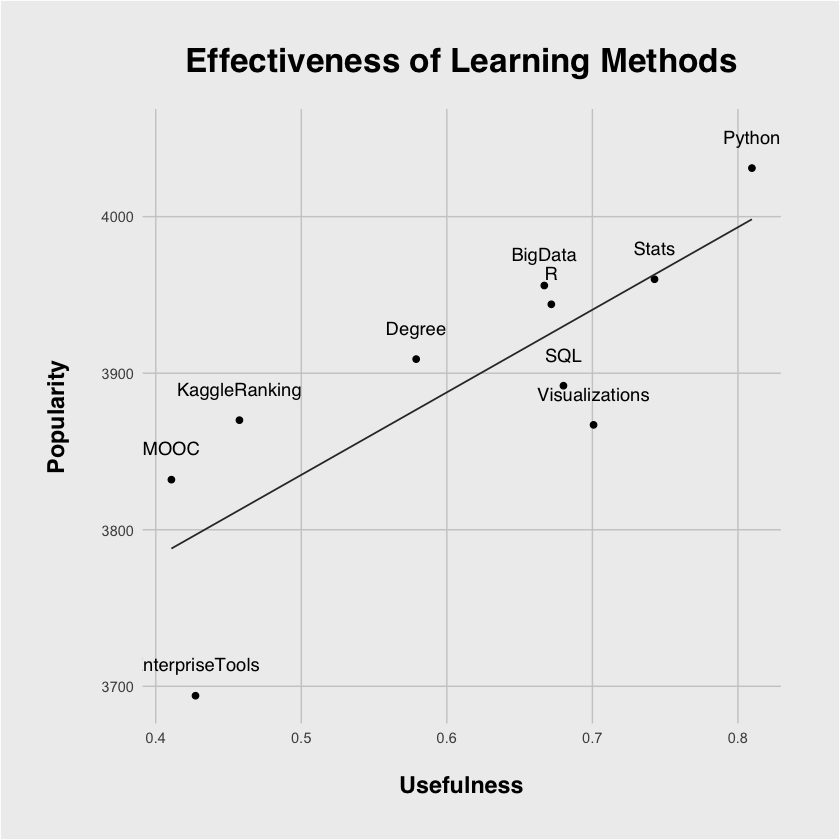

In [13]:
# Get all column names that begin with "JobSkillImportance" and end in a letter
platforms <- grep("^JobSkillImportance.*[A-z]$", names(results), value=T)

names <- c()
popularities <- c()
scores <- c()

for (platform in platforms) {
    usefulness <- results %>%
        group_by_(platform) %>%
        count()
    
    # Popularity = the number of people who responded to this question
    popularity <- usefulness[[2]][2] + usefulness[[2]][3] + usefulness[[2]][4]
    
    # Usefulness = a weighted average determining the usefulness of this platform
    score <- (usefulness[[2]][2] * 1 + usefulness[[2]][3] * 0.5 + usefulness[[2]][4] * 0) / popularity
    
    names <- c(names, gsub("JobSkillImportance", "", platform))
    popularities <- c(popularities, popularity)
    scores <- c(scores, score)
}

scores_df <- data.frame(
    Popularity = popularities,
    Usefulness = scores,
    Name = names
)

ggplot(scores_df, aes(x = Usefulness, y = Popularity)) +
    ggtitle("Effectiveness of Learning Methods") +
    geom_point() +
    geom_smooth(method = lm, se = FALSE, color = "#333333", size = 0.5) +
    geom_text(aes(label = Name, family = "Helvetica"), nudge_y = 20) +
    theme(
        plot.background = element_rect(fill = "#eeeeee"),
        panel.background = element_rect(fill = "#eeeeee"),
        panel.grid.major = element_line(size = 0.4, linetype = "solid", color = "#cccccc"),
        panel.grid.minor = element_line(size = 0),
        plot.title = element_text(size = 20, family = "Helvetica", face = "bold", hjust = 0.5, margin = margin(b = 20)),
        axis.title = element_text(size = 14, family = "Helvetica", face = "bold"),
        axis.title.x = element_text(margin = margin(t = 20)),
        axis.title.y = element_text(margin = margin(r = 20)),
        axis.ticks = element_blank(),
        plot.margin = unit(c(1, 1.25, 1, 1), "cm")
    )

Interestingly enough, MOOCs scored the lowest in terms of usefulness, yet online courses scored the second highest in the last question. Therefore, while courses can be good for learning about data science, they should not be shown as a form of qualification to employers. We can see that **knowledge of Python, advanced statistics, and vizualization tools ranked the highest** in terms of skills that are useful in getting data science jobs.

## Tools in the real world

In [14]:
# Get all column names that begin with "WorkToolsFrequency" and end in a letter
platforms <- grep("^WorkToolsFrequency.*[A-z]$", names(results), value=T)

names <- c()
popularities <- c()
scores <- c()

for (platform in platforms) {
    usefulness <- results %>%
        group_by_(platform) %>%
        count()
    
    # Popularity = the number of people who responded to this question
    popularity <- usefulness[[2]][2] + usefulness[[2]][3] + usefulness[[2]][4]
    
    # Usefulness = a weighted average determining the usefulness of this platform
    score <- (usefulness[[2]][2] * 1 + usefulness[[2]][3] * 0.67 + usefulness[[2]][4] * 0.33 + usefulness[[2]][5] * 0) / popularity
    
    names <- c(names, gsub("WorkToolsFrequency", "", platform))
    popularities <- c(popularities, popularity)
    scores <- c(scores, score)
}

scores_df <- data.frame(
    Popularity = popularities,
    Usefulness = scores,
    Name = names
)

scores_df %>% arrange(desc(Usefulness * Popularity))

Popularity,Usefulness,Name
4970,0.8674366,Python
3441,0.8519645,SQL
3504,0.8101227,R
2424,0.8161510,Jupyter
1491,0.8292891,Unix
1392,0.6985201,TensorFlow
1334,0.7155772,AWS
1064,0.6829135,Tableau
957,0.6904493,Java
908,0.7068502,NoSQL


## Majors and likely positions

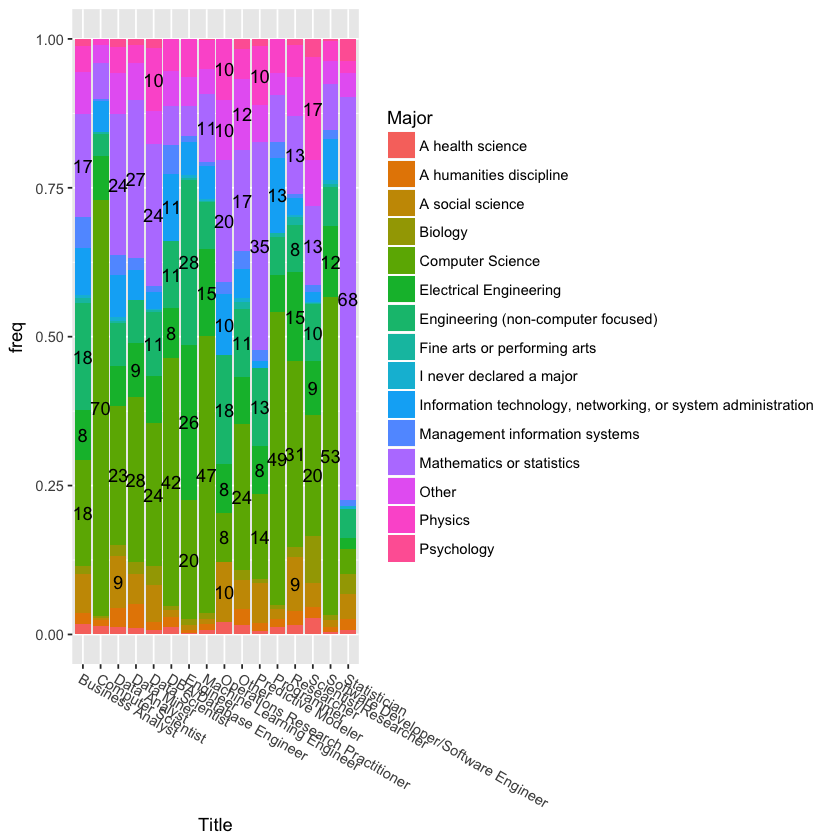

In [15]:
results %>%
    rename(Major = MajorSelect, Title = CurrentJobTitleSelect) %>%
    filter(Title != "", Major != "") %>%
    group_by(Title, Major) %>%
    summarize(n = n()) %>%
    mutate(freq = n / sum(n)) %>%
    ggplot() +
    geom_bar(aes(y = freq, x = Title, fill = Major), stat = "identity", position = position_stack(reverse = TRUE)) +
    geom_text(aes(y = freq, x = Title, label = ifelse(freq > 0.08, round(freq * 100), "")), position = position_stack(vjust = 0.5)) +
    theme(axis.text.x = element_text(angle = 330, hjust = 0))